In [3]:
import numpy as np
from sympy import *
import matplotlib.pyplot as plt
from dynamics import Dynamics
import pandas as pd
import os
import time

In [14]:
import numpy as np
import pandas as pd
from dynamics import Dynamics  # make sure your Dynamics class file is in same folder

# ============================================================
# Run "truth" simulation with very small Δt
# ============================================================

truth_path = "../data/truth_reference.csv"

if os.path.exists(truth_path):
    print("Truth run exists, done!")
    truth = pd.read_csv(truth_path)
else:
    dt_truth = 0.002  # small step, e.g., 0.1 ms
    xhat0 = np.array([0,0,0,0,0,0,1,0,0,0])
    dyn = Dynamics(dt=dt_truth, x0=xhat0)
    dyn.setup_eom()
    dyn.run_rk4(xhat0)

    # Convert results to DataFrame
    data = np.column_stack((dyn.ts, np.array(dyn.states)))
    cols = ['t', 'w1','w2','w3','v1','v2','v3','qw','qx','qy','qz']
    df = pd.DataFrame(data, columns=cols)

    # Save to CSV
    df.to_csv(truth_path, index=False)
    print("✅ Saved truth data to truth_reference.csv")




Truth run exists, done!


In [15]:
# ============================================================
# Configuration
# ============================================================

# Folder for saved simulation data
save_dir = "../data/dt_runs"
os.makedirs(save_dir, exist_ok=True)

# Time steps to simulate
dt_values = np.array([0.4, 0.2, 0.1, 0.05, 0.025, 0.0125])  
xhat0 = np.array([0,0,0,0,0,0,1,0,0,0])

# ============================================================
# Function to run and save a single simulation
# ============================================================

def run_and_save(dt):
    filename = f"rk4_dt{dt:.3f}.csv".replace('.', 'p')
    filepath = os.path.join(save_dir, filename)

    # Skip if it already exists
    if os.path.exists(filepath):
        print(f"{filename} already exists, skipping simulation.")
        return

    print(f"\nRunning simulation for Δt = {dt:.4f} s ...")
    dyn = Dynamics(dt=dt, x0=xhat0)
    dyn.setup_eom()

    start = time.time()
    dyn.test_eom(xhat0)
    runtime = time.time() - start

    data = np.column_stack((dyn.ts, np.array(dyn.states)))
    cols = ['t', 'w1','w2','w3','v1','v2','v3','qw','qx','qy','qz']
    df = pd.DataFrame(data, columns=cols)
    df.to_csv(filepath, index=False)

    print(f"Saved {filename} ({len(dyn.ts)} steps, runtime {runtime/60:.1f} min)")
    return filepath

# ============================================================
# Run simulations for each dt and save results
# ============================================================

for dt in dt_values:
    run_and_save(dt)

print("\nAll simulations complete.")


rk4_dt0p400pcsv already exists, skipping simulation.
rk4_dt0p200pcsv already exists, skipping simulation.
rk4_dt0p100pcsv already exists, skipping simulation.
rk4_dt0p050pcsv already exists, skipping simulation.
rk4_dt0p025pcsv already exists, skipping simulation.
rk4_dt0p013pcsv already exists, skipping simulation.

All simulations complete.



=== Metric: w3 ===
Δt=0.0125, full error = 2.573e-03
Δt=0.0250, full error = 8.849e-03
Δt=0.0500, full error = 2.773e-02
Δt=0.1000, full error = 6.165e-02
Δt=0.2000, full error = 1.237e-01
Δt=0.4000, full error = 2.433e-01


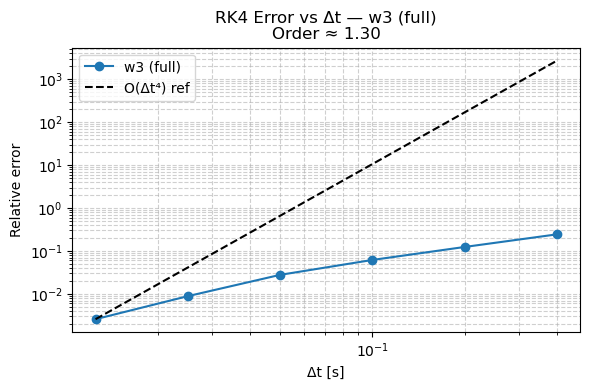

Δt=0.0125, burn_mid error = 2.248e-02
Δt=0.0250, burn_mid error = 5.219e-02
Δt=0.0500, burn_mid error = 1.211e-01
Δt=0.1000, burn_mid error = 2.373e-01
Δt=0.2000, burn_mid error = 4.564e-01
Δt=0.4000, burn_mid error = 8.027e-01


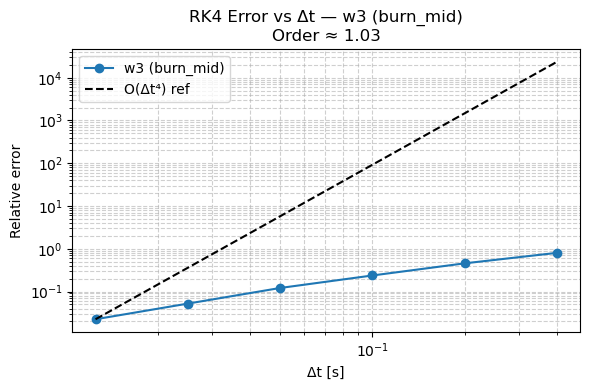

Δt=0.0125, coast_mid error = 2.403e-03
Δt=0.0250, coast_mid error = 8.594e-03
Δt=0.0500, coast_mid error = 2.730e-02
Δt=0.1000, coast_mid error = 6.094e-02
Δt=0.2000, coast_mid error = 1.226e-01
Δt=0.4000, coast_mid error = 2.422e-01


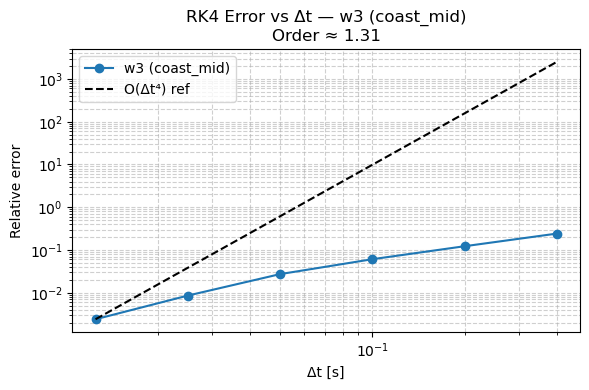


=== Metric: v3 ===
Δt=0.0125, full error = 2.828e-03
Δt=0.0250, full error = 7.293e-03
Δt=0.0500, full error = 1.994e-02
Δt=0.1000, full error = 4.281e-02
Δt=0.2000, full error = 8.758e-02
Δt=0.4000, full error = 1.816e-01


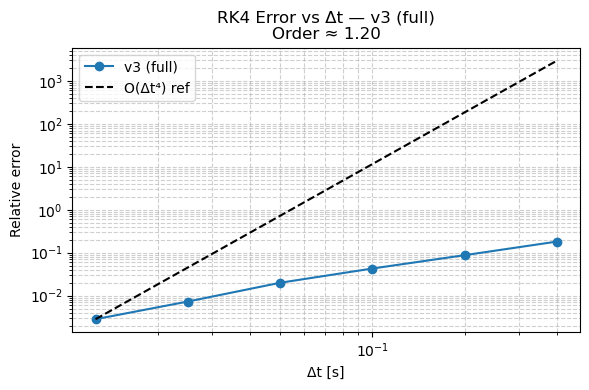

Δt=0.0125, burn_mid error = 5.761e-03
Δt=0.0250, burn_mid error = 1.461e-02
Δt=0.0500, burn_mid error = 3.840e-02
Δt=0.1000, burn_mid error = 8.046e-02
Δt=0.2000, burn_mid error = 1.743e-01
Δt=0.4000, burn_mid error = 3.855e-01


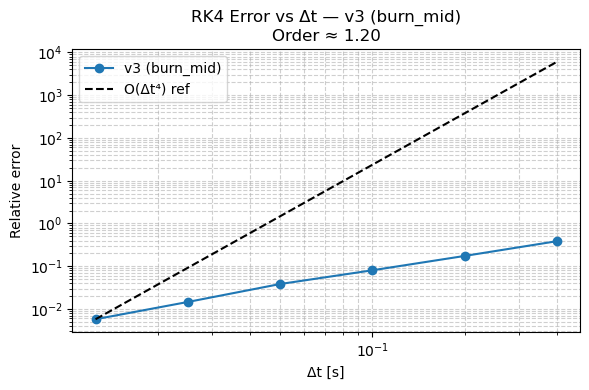

Δt=0.0125, coast_mid error = 3.794e-04
Δt=0.0250, coast_mid error = 1.893e-03
Δt=0.0500, coast_mid error = 8.159e-03
Δt=0.1000, coast_mid error = 2.019e-02
Δt=0.2000, coast_mid error = 4.238e-02
Δt=0.4000, coast_mid error = 9.040e-02


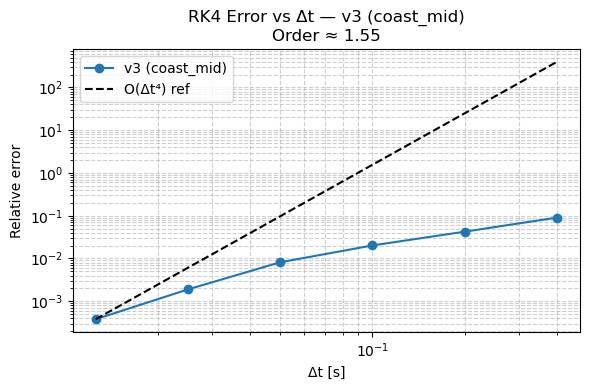

In [20]:
# ============================================================
# Configuration
# ============================================================
data_dir = "../data/dt_runs"
truth_path = "../data/truth_reference.csv"
dt_values = [0.0125, 0.025, 0.05, 0.1, 0.2, 0.4]   # your coarse steps
metrics = [("w3", 2), ("v3", 5)]           # (label, column index)

# Define your Dynamics timing (same defaults as class)
t_burnout = 1.971
t_apogee  = 13.571
t_launch  = 0.164

# Define analysis windows
windows = {
    "full": (0.0, t_apogee),
    "burn_mid": (t_launch + 0.02, t_burnout - 0.05),
    "coast_mid": (t_burnout + 0.02, t_apogee - 0.02),
}

# ============================================================
# Load truth reference
# ============================================================
truth = pd.read_csv(truth_path)
t_ref = truth["t"].values
states_ref = truth.iloc[:, 1:].values  # w1,w2,w3,v1,v2,v3,qw,qx,qy,qz

# Helper function
def relative_error(y, y_ref, t, t_ref, t0, t1):
    y_ref_interp = np.interp(t, t_ref, y_ref)
    mask = (t >= t0) & (t <= t1)
    if not np.any(mask): 
        return np.nan
    y, y_ref_interp = y[mask], y_ref_interp[mask]
    return np.linalg.norm(y - y_ref_interp) / np.linalg.norm(y_ref_interp)

# ============================================================
# Compute errors for each dt, metric, and window
# ============================================================
results = []

for metric_name, col in metrics:
    print(f"\n=== Metric: {metric_name} ===")
    y_ref = states_ref[:, col]

    for win_name, (t0, t1) in windows.items():
        errs = []

        for dt in dt_values:
            file_path = os.path.join(data_dir, f"rk4_dt{dt:.3f}pcsv".replace('.', 'p'))
            if not os.path.exists(file_path):
                print(f"⚠ Missing {file_path}, skipping.")
                continue

            df = pd.read_csv(file_path)
            t = df["t"].values
            y = df.iloc[:, col+1].values  # +1 because col index excludes 't'

            err = relative_error(y, y_ref, t, t_ref, t0, t1)
            errs.append(err)
            print(f"Δt={dt:.4f}, {win_name} error = {err:.3e}")

        # Compute order (slope in log–log)
        errs = np.array(errs)
        good = np.isfinite(errs) & (errs > 0)
        if good.sum() >= 2:
            order = np.polyfit(np.log(np.array(dt_values)[good]), np.log(errs[good]), 1)[0]
        else:
            order = np.nan

        # Plot error vs dt
        plt.figure(figsize=(6,4))
        plt.loglog(dt_values, errs, 'o-', label=f"{metric_name} ({win_name})")
        if np.isfinite(errs[0]):
            plt.loglog(dt_values, errs[0]*(np.array(dt_values)/dt_values[0])**4, 'k--', label='O(Δt⁴) ref')
        plt.xlabel("Δt [s]")
        plt.ylabel("Relative error")
        plt.title(f"RK4 Error vs Δt — {metric_name} ({win_name})\nOrder ≈ {order:.2f}")
        plt.grid(True, which="both", ls="--", alpha=0.6)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Save one row per window + metric
        results.append({
            "metric": metric_name,
            "window": win_name,
            "order": order,
            "errors": errs.tolist(),
        })



⏩ Loading saved run for Δt = 0.4
Δt=0.4000, relative error = 2.426e-01
⏩ Loading saved run for Δt = 0.2
Δt=0.2000, relative error = 1.235e-01
⏩ Loading saved run for Δt = 0.1
Δt=0.1000, relative error = 6.159e-02
⏩ Loading saved run for Δt = 0.05
Δt=0.0500, relative error = 2.771e-02
⏩ Loading saved run for Δt = 0.025
Δt=0.0250, relative error = 8.845e-03
Observed convergence order ≈ 1.17


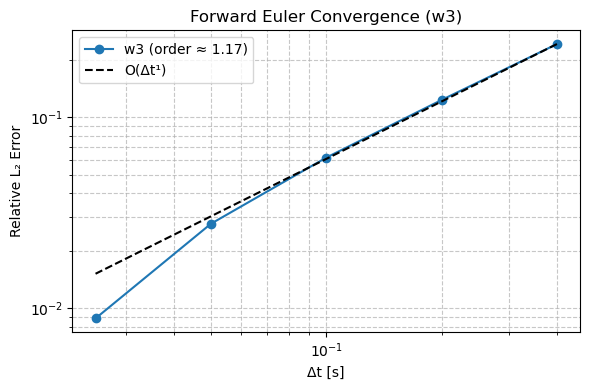


✅ Observed convergence order for w3: ≈ 1.17


In [10]:
# ============================================================
# CONFIGURATION
# ============================================================
dt_values = [0.4, 0.2, 0.1, 0.05, 0.025]  # from coarse → fine
truth_dt = 0.001                          # very small for reference
save_dir = "../data/euler_runs"
os.makedirs(save_dir, exist_ok=True)

xhat0 = np.array([0,0,0,0,0,0,1,0,0,0])   # initial state
metric = "w3"                             # can also change to "v3"
col_idx = 3                               # w3 = 3, v3 = 6
t_final = 13.571                          # same as apogee time


# ============================================================
# FUNCTION: run Euler sim using Dynamics.test_eom()
# ============================================================
def run_euler(dt, label=""):
    dyn = Dynamics(dt=dt, x0=xhat0)
    dyn.setup_eom()

    print(f"\n🚀 Running Forward Euler ({label}) with Δt = {dt:.4f}s ...")
    start = time.time()
    dyn.test_eom(xhat0.copy())
    runtime = time.time() - start

    data = np.column_stack((dyn.ts, np.array(dyn.states)))
    cols = ['t', 'w1','w2','w3','v1','v2','v3','qw','qx','qy','qz']
    df = pd.DataFrame(data, columns=cols)
    filepath = os.path.join(save_dir, f"euler_dt{dt:.3f}.csv".replace('.', 'p'))
    df.to_csv(filepath, index=False)
    print(f"✅ Saved {filepath} ({runtime/60:.1f} min)")
    return df


# ============================================================
# STEP 1: RUN TRUTH SIMULATION
# ============================================================
# Instead of running an Euler truth:
truth = pd.read_csv("../data/truth_reference.csv")
t_ref = truth["t"].values
y_ref = truth.iloc[:, col_idx].values

# ============================================================
# STEP 2: RUN COARSER SIMULATIONS
# ============================================================
errors = []

for dt in dt_values:
    filepath = os.path.join(save_dir, f"euler_dt{dt:.3f}.csv".replace('.', 'p'))
    if os.path.exists(filepath):
        print(f"⏩ Loading saved run for Δt = {dt}")
        df = pd.read_csv(filepath)
    else:
        df = run_euler(dt, label=f"dt={dt:.3f}")

    t = df["t"].values
    y = df.iloc[:, col_idx].values

    # interpolate truth onto coarse time grid
    y_truth_interp = np.interp(t, t_ref, y_ref)
    err = np.linalg.norm(y - y_truth_interp) / np.linalg.norm(y_truth_interp)
    errors.append(err)
    print(f"Δt={dt:.4f}, relative error = {err:.3e}")

# ============================================================
# STEP 3: COMPUTE ORDER AND PLOT
# ============================================================
p = np.polyfit(np.log(dt_values), np.log(errors), 1)[0]
print(f"Observed convergence order ≈ {p:.2f}")


plt.figure(figsize=(6,4))
plt.loglog(dt_values, errors, 'o-', label=f'{metric} (order ≈ {p:.2f})')
plt.loglog(dt_values, errors[0]*(np.array(dt_values)/dt_values[0])**1, 'k--', label='O(Δt¹)')
plt.xlabel("Δt [s]")
plt.ylabel("Relative L₂ Error")
plt.title(f"Forward Euler Convergence ({metric})")
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

print(f"\n✅ Observed convergence order for {metric}: ≈ {p:.2f}")
